# **Fraud detection model**

Pipeline: Original Data -> Data Cleaning -> Data Preprocessing -> Model Creation ->Model Evaluation

In [ ]:
import pandas as pd
import csv
import numpy as np
import sklearn 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import *
import imblearn
from sklearn.ensemble.forest import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
!pip install pyspark
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.ml.classification import LogisticRegression
from sklearn.utils import resample


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from

     |████████████████████████████████| 212.3MB 78kB/s 
     |████████████████████████████████| 204kB 21.4MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=0dca68b00a9c43d94b460cfc1bfc03590e7e09c964cd5209ad5513f88891fece
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


# **Importing Dataset**

In [ ]:
#Or you can read the dataset by uploding dataset from your computer
from google.colab import files
uploaded = files.upload()

Saving Dataset.csv to Dataset (1).csv


In [ ]:
fraud_df = pd.read_csv("Dataset.csv")
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72271 entries, 0 to 72270
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            72271 non-null  int64  
 1   type            72271 non-null  object 
 2   amount          72271 non-null  float64
 3   nameOrig        72271 non-null  object 
 4   oldbalanceOrg   72271 non-null  float64
 5   newbalanceOrig  72270 non-null  float64
 6   nameDest        72270 non-null  object 
 7   oldbalanceDest  72270 non-null  float64
 8   newbalanceDest  72270 non-null  float64
 9   isFraud         72270 non-null  float64
 10  isFlaggedFraud  72270 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 6.1+ MB


**Feature Description**
* step - integer - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
* type - string/categorical - type of transaction: CASH-IN, CASH-OUT, DEBIT PAYMENT and TRANSFER.

* amount - float - amount of the transaction in local currency.

* nameOrig - string - customer who initiated the transaction

* oldbalanceOrg - float initial balance before the transaction

* newbalanceOrig - float - new balance after the transaction

* nameDest - string - customer who is the recipient of the transaction

* oldbalanceDest - float - initial balance of recipient before the transaction.

* newbalanceDest - float - new balance of recipient after the transaction.

* isFraud - boolean/binary - determines if transaction is fraudulent (encoded as 1) or valid (encoded as 0)

* isFlaggedFraud - boolean/binary - determines if transaction is flagged as fraudulent (encoded as 1) or not flagged at all (encoded as 0). An observation is flagged if the transaction is fraudulent and it involved a transfer of over 200,000 in the local currency.

In [ ]:
#reading dataset from google drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)#clicking the link and copy the authorization codes
%cd /content/drive/My Drive/Functional Validation for Fraud/Dataset/
fraud_df = pd.read_csv("fraud_df.csv")
fraud_df_orig = fraud_df

Mounted at /content/drive
/content/drive/My Drive/Functional Validation for Fraud/Dataset


In [ ]:
fraud_df_orig

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [ ]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
fraud_df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

The dataset is highly unbalanced. 0: no fraud >> 1: fraud (about 0.1291% of all are fraud) We use the combination of SMOTE (Synthetic Minority Oversampling Technique) to oversample the minority class and random under-sampling to trim the number of examples in the majority class

# **Data preprocessing**

In [ ]:
#In the nameOrig and nameDest, the first character for each value is "C" or "M"
#"C" represent "customer" and "M" represent Merchant
#Creating a new categorical feature called "transaction_accounts"

# filling feature column
fraud_df.loc[fraud_df.nameOrig.str.contains('C') & fraud_df.nameDest.str.contains('C'),"transaction_accounts"] = "CC" #"CC" (Customer to Customer)
fraud_df.loc[fraud_df.nameOrig.str.contains('C') & fraud_df.nameDest.str.contains('M'),"transaction_accounts"] = "CM" #"CM" (Customer to Merchant)
fraud_df.loc[fraud_df.nameOrig.str.contains('M') & fraud_df.nameDest.str.contains('C'),"transaction_accounts"] = "MC" #"MC" (Merchant to Customer)
fraud_df.loc[fraud_df.nameOrig.str.contains('M') & fraud_df.nameDest.str.contains('M'),"transaction_accounts"] = "MM" #"MM" (Merchant to Merchant)

#creating a new feature called "HourOfDay" which represent the time in a day when the transction happens
fraud_df.HourOfDay = fraud_df.step % 24

#dropping irrelevant features
fraud_df = fraud_df.drop(["step","isFlaggedFraud","nameOrig","nameDest"],axis=1)

#One hot encoding for categorical values
fraud_df = pd.get_dummies(fraud_df, sparse=True)

#Normalize numeric variables
cols_to_norm = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
fraud_df[cols_to_norm] = fraud_df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
fraud_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if sys.path[0] == '':


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,transaction_accounts_CC,transaction_accounts_CM
0,0.000106,0.002855,0.003233,0.000000,0.000000,0,0,0,0,1,0,0,1
1,0.000020,0.000357,0.000391,0.000000,0.000000,0,0,0,0,1,0,0,1
2,0.000002,0.000003,0.000000,0.000000,0.000000,1,0,0,0,0,1,1,0
3,0.000002,0.000003,0.000000,0.000059,0.000000,1,0,1,0,0,0,1,0
4,0.000126,0.000697,0.000603,0.000000,0.000000,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,0.003674,0.005701,0.000000,0.000000,0.000954,1,0,1,0,0,0,1,0
6362616,0.068272,0.105923,0.000000,0.000000,0.000000,1,0,0,0,0,1,1,0
6362617,0.068272,0.105923,0.000000,0.000192,0.017912,1,0,1,0,0,0,1,0
6362618,0.009195,0.014265,0.000000,0.000000,0.000000,1,0,0,0,0,1,1,0


# **Building Service Agents**

In [ ]:
from pyspark.ml.classification import LogisticRegressionModel
from pyspark.ml.classification import NaiveBayesModel
from joblib import dump, load
import pyspark.mllib.classification
from pyspark.ml.classification import LogisticRegression
from sklearn.ensemble.forest import RandomForestClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import NaiveBayes
from sklearn.ensemble import GradientBoostingClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import keras.backend as K
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from pyspark.ml.classification import LinearSVCModel
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
class service_agents:
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def spliting_data(self):
    X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42,stratify=self.y)
    return(X_train, X_test, y_train, y_test)
    
  def balancing_data(self,X_train, y_train):
    ros = RandomOverSampler(random_state=0)
    X_res_train, y_res_train = ros.fit_resample(X_train, y_train)
    return(X_res_train, y_res_train)

  def LogisticRegression(self,train_sdf,test_sdf):
    lr = LogisticRegression(featuresCol = 'features', labelCol = 'label',elasticNetParam = 1)
    lr_model = lr.fit(train_sdf)
    lr_model.write().overwrite().save("lr_model.model")
    predictions = lr_model.transform(test_sdf)
    y_true = predictions.select(['label']).collect()
    y_pred = predictions.select(['prediction']).collect()
    print(classification_report(y_true, y_pred))
    return(f1_score(y_true, y_pred))

  def RandomForest(self,X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    dump(rf, 'rf.joblib') 
    y_pred= rf.predict(X_test)
    return(f1_score(y_test, y_pred))

  def Gaussian_Naive_Bayes(self,train_sdf,test_sdf):
    gnb = NaiveBayes(labelCol="label", featuresCol="features",modelType="gaussian")
    gnb_model = gnb.fit(train_sdf)
    gnb_model.write().overwrite().save("gnb_model.model")
    predictions = gnb_model.transform(test_sdf)
    y_true = predictions.select(['label']).collect()
    y_pred = predictions.select(['prediction']).collect()
    print(classification_report(y_true, y_pred))
    return(f1_score(y_true, y_pred))

  def adaboost(self,X_train, X_test, y_train, y_test):
    ada = AdaBoostClassifier(n_estimators=50,learning_rate=0.1,base_estimator=DecisionTreeClassifier())
    ada.fit(X_train, y_train)
    dump(ada, 'ada.joblib') 
    y_pred = ada.predict(X_test)
    return(f1_score(y_test, y_pred))

  def Neural_nets(self,X_train, X_test, y_train, y_test):
    nn = Sequential()
    nn.add(Dense(12, input_dim=12, activation='relu'))
    nn.add(Dense(20, activation='relu'))
    nn.add(Dense(1, activation='sigmoid'))
    nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    nn.fit(X_train, y_train, epochs=50, batch_size=512)
    nn.save("nn.model")
    y_pred = nn.predict_classes(X_test)
    return(f1_score(y_test, y_pred))
  def SVM(self,X_train, X_test, y_train, y_test):
    clf = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-5))
    clf.fit(X_train, y_train)
    dump(clf, 'clf.joblib') 
    y_pred = clf.predict(X_test)
    return(f1_score(y_test, y_pred))
  def GradientBoost(self,X_train, X_test, y_train, y_test):
    gb = GradientBoostingClassifier(max_depth=30).fit(X_train, y_train)
    dump(gb, 'gb.joblib') 
    y_pred = gb.predict(X_test)
    return(f1_score(y_test, y_pred))

  def spark_pre(self,df,target_col):
      # test_df = np.column_stack((X_test,y_test)) 
      # test_df = pd.DataFrame(test_df,columns = all_columns)
      all_columns = list(df.columns.values) 
      df.to_csv('df.csv')
      sdf = spark.read.csv("df.csv", inferSchema=True,header=True)

      all_columns.remove(target_col)
      assembler = VectorAssembler(inputCols=all_columns, outputCol='features')
      label_stringIdx = StringIndexer(inputCol = target_col, outputCol = 'label')

      pipe = Pipeline(stages = [assembler,label_stringIdx])
      sdf=pipe.fit(sdf).transform(sdf)
      return(sdf)

  def selecting_models(self,X_train, X_test, y_train, y_test,train_sdf, test_sdf,N):#run all models and select N best models
    print_info = ["LogisticRegression","RandomForest","Neural Nets","Gaussian Naive Bayes","adaboost","SVM","GradientBoost"]
    model_f1 = []

    f1_lr = self.LogisticRegression(train_sdf,test_sdf)
    model_f1.append(f1_lr)
    print(f1_lr)

    f1_rf = self.RandomForest(X_train, X_test, y_train, y_test)
    model_f1.append(f1_rf)
    print(f1_rf)

    f1_nn = self.Neural_nets(X_train, X_test, y_train, y_test)
    model_f1.append(f1_nn)
    print(f1_nn)

    f1_nb= self.Gaussian_Naive_Bayes(train_sdf,test_sdf)
    model_f1.append(f1_nb)
    print(f1_nb)

    f1_ada = self.adaboost(X_train, X_test, y_train, y_test)
    model_f1.append(f1_ada)
    print(f1_ada)

    f1_svm= self.SVM(X_train, X_test, y_train, y_test)
    model_f1.append(f1_svm)
    print(f1_svm)

    #Running time so long
    f1_gb= self.GradientBoost(X_train, X_test, y_train, y_test)
    model_f1.append(f1_gb)
    print(f1_gb)

    best_model = []
    f1_score = []
    order = np.flip(np.argsort(model_f1))
    print(order)
    for i in range(N):
      print("the NO.", i, ' model is ',print_info[order[i]],'with f1 score:',model_f1[order[i]])
      best_model.append(print_info[order[i]])
      f1_score.append(model_f1[order[i]])
    return(best_model,f1_score)
  def get_f1(self, X_test, y_test, test_sdf, bestmodels='Neural Nets'):
    if bestmodels == 'LogisticRegression':
      lr_model = LogisticRegressionModel.load("lr_model.model")
      predictions = lr_model.transform(test_sdf)
      y_true = predictions.select(['label']).collect()
      y_pred = predictions.select(['prediction']).collect()
      print(classification_report(y_true, y_pred))
      return(f1_score(y_true, y_pred))
    elif bestmodels == 'Gaussian Naive Bayes':
      gnb_model = NaiveBayesModel.load("gnb_model.model")
      predictions = gnb_model.transform(test_sdf)
      y_true = predictions.select(['label']).collect()
      y_pred = predictions.select(['prediction']).collect()
      print(classification_report(y_true, y_pred))
      return(f1_score(y_true, y_pred))  
    elif bestmodels == 'SVM':
      lsvc_model = load("rf.joblib")
      y_pred= lsvc_model.predict(X_test)
      return(f1_score(y_test, y_pred))
    elif bestmodels == 'RandomForest':
      rf_model = load('rf.joblib') 
      y_pred= rf_model.predict(X_test)
      return(f1_score(y_test, y_pred))
    elif bestmodels == "GradientBoost":
      gb_model = load('gb.joblib') 
      y_pred= gb_model.predict(X_test)
      return(f1_score(y_test, y_pred))   
    elif bestmodels == "adaboost":
      ada_model = load('ada.joblib') 
      y_pred= ada_model.predict(X_test)
      return(f1_score(y_test, y_pred))  
    elif bestmodels =="Neural Nets":
      neural_net = keras.models.load_model("nn.model")   
      y_pred = neural_net.predict_classes(X_test)
      return(f1_score(y_test, y_pred))
  def bootstrap(self,X,y,target,top_k_model = [],challenge_size = 10000,resample_num=200): 
    f1 = {}
    for model in top_k_model:
      f1[model] = []

    for i in range(resample_num):
      X_boot, y_boot = resample(X, y, stratify = y,  n_samples = challenge_size) 
      
      all_columns = list(X_boot.columns.values) + [target]
      boot_df = np.column_stack((X_boot,y_boot)) 
      boot_df = pd.DataFrame(boot_df,columns = all_columns)
      boot_sdf = self.spark_pre(boot_df,target)

      for model in top_k_model:
        f1[model].append(self.get_f1(X_boot, y_boot, boot_sdf, bestmodels=model))
    return(f1)
  def functional_validation(self, sample_data, popmean, model='', alpha=0.05, alternative='less'):
    print(model)
    print('Null Hypothesis: the accuracy of model is verified or H_0 = ',popmean)
    print('Alternative Hypothesis: the accuracy of model is not verified or H_0 < ',popmean)
    print('The alpha: ',alpha)
    t, p = stats.ttest_1samp(sample_data, popmean)
    if alternative == 'greater' and (p/2 < alpha) and t > 0:
        print('The result with p-value ',p/2,' reject Null Hypothesis and the functionality/accuracy of ',model,' is not verifed.')
    elif alternative == 'less' and (p/2 < alpha) and t < 0:
        print('The result with p-value ',p/2,' reject Null Hypothesis and the functionality/accuracy of ',model,' is not verifed.')
    else: print('The result with p-value ',p/2, 'does not reject the Null Hypothesis and the functionality/accuracy of ',model,' is verified.')





# **Selection Top K Models**

In [ ]:
from pyspark.ml.feature import StringIndexer
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
y = fraud_df['isFraud']
X = fraud_df.drop(columns=['isFraud'])

#X_1 and y_1 are used for training
X_1, X_2, y_1, y_2 = train_test_split(X, y, test_size=0.5, random_state=42,stratify=y)

#Creating a class object called test
test = service_agents(X_1,y_1)
#Spliting into Train and Test
X_train, X_test, y_train, y_test = test.spliting_data()
#Balancing dataset
X_res_train, y_res_train = test.balancing_data(X_train, y_train)
#Preparing Spark dataframe

all_columns = list(X.columns.values) + ['isFraud']
train_df = np.column_stack((X_res_train,y_res_train)) 
train_df = pd.DataFrame(train_df,columns = all_columns)
train_sdf = test.spark_pre(train_df,'isFraud')

test_df = np.column_stack((X_test,y_test)) 
test_df = pd.DataFrame(test_df,columns = all_columns)
test_sdf = test.spark_pre(test_df,'isFraud')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#Training
best_model,f1score = test.selecting_models(X_res_train, X_test, y_res_train, y_test,train_sdf,test_sdf,3)
print(best_model)
print(f1score)

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97    635441
         1.0       0.02      0.93      0.04       821

    accuracy                           0.95    636262
   macro avg       0.51      0.94      0.51    636262
weighted avg       1.00      0.95      0.97    636262

0.042717793474604776
0.8465116279069768
Epoch 1/50
9929/9929 [==============================] - 15s 1ms/step - loss: 0.2907 - accuracy: 0.8598
Epoch 2/50
9929/9929 [==============================] - 13s 1ms/step - loss: 0.1000 - accuracy: 0.9721
Epoch 3/50
9929/9929 [==============================] - 13s 1ms/step - loss: 0.0715 - accuracy: 0.9813
Epoch 4/50
9929/9929 [==============================] - 14s 1ms/step - loss: 0.0566 - accuracy: 0.9847
Epoch 5/50
9929/9929 [==============================] - 14s 1ms/step - loss: 0.0492 - accuracy: 0.9868
Epoch 6/50
9929/9929 [==============================] - 14s 1ms/step - loss: 0.0446 - accuracy: 0.9880
Epoch 7/50
9929

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.27138838325335096
              precision    recall  f1-score   support

         0.0       1.00      0.57      0.72    635441
         1.0       0.00      1.00      0.01       821

    accuracy                           0.57    636262
   macro avg       0.50      0.78      0.36    636262
weighted avg       1.00      0.57      0.72    636262

0.005924393454955803
0.8525845564773453
              precision    recall  f1-score   support

         0.0       1.00      0.59      0.74    635441
         1.0       0.00      0.98      0.01       821

    accuracy                           0.59    636262
   macro avg       0.50      0.78      0.37    636262
weighted avg       1.00      0.59      0.74    636262

0.006097284212118919
0.8567823343848581
[6 4 1 2 0 5 3]
the NO. 0  model is  GradientBoost with f1 score: 0.8567823343848581
the NO. 1  model is  adaboost with f1 score: 0.8525845564773453
the NO. 2  model is  RandomForest with f1 score: 0.8465116279069768
['GradientBoost', 'adaboost',

In [ ]:
f1score=[0.8567823343848581, 0.8525845564773453, 0.8465116279069768]
top_k_model = ['GradientBoost', 'adaboost', 'RandomForest']

# **Functional Validation: Bootstrapping**

In [ ]:
f1_boot = test.bootstrap(X_2,y_2,target = 'isFraud',top_k_model=['GradientBoost', 'adaboost', 'RandomForest'])
f1_boot

{'GradientBoost': [0.8,
  0.8799999999999999,
  0.8461538461538461,
  0.9600000000000001,
  0.888888888888889,
  0.8148148148148148,
  0.7826086956521738,
  0.8148148148148148,
  0.8461538461538461,
  0.888888888888889,
  0.8,
  0.8799999999999999,
  0.888888888888889,
  0.8461538461538461,
  0.9230769230769231,
  0.8799999999999999,
  0.8799999999999999,
  0.9166666666666666,
  0.8461538461538461,
  0.8333333333333333,
  0.8799999999999999,
  0.7142857142857142,
  0.888888888888889,
  0.7826086956521738,
  0.9230769230769231,
  0.8695652173913044,
  0.8799999999999999,
  0.8275862068965517,
  0.7692307692307693,
  0.9600000000000001,
  0.8799999999999999,
  0.8695652173913044,
  0.962962962962963,
  0.888888888888889,
  0.9230769230769231,
  0.9600000000000001,
  1.0,
  0.962962962962963,
  0.7272727272727274,
  0.8,
  0.962962962962963,
  0.8461538461538461,
  0.9230769230769231,
  0.7000000000000001,
  0.8799999999999999,
  0.8571428571428571,
  0.6666666666666666,
  0.8799999999999

In [ ]:
for model in top_k_model:
  print("Average of F1 score of", model," is: ",np.mean(f1_boot[model]))
  print("Variance of F1 score of", model, " is: ", sum((x - np.mean(f1_boot[model])) ** 2 for x in f1_boot[model]) / len(f1_boot[model]))

Average of F1 score of GradientBoost  is:  0.8700326356246897
Variance of F1 score of GradientBoost  is:  0.004368986481596918
Average of F1 score of adaboost  is:  0.8623339358098728
Variance of F1 score of adaboost  is:  0.004496104919598253
Average of F1 score of RandomForest  is:  0.8620983613144034
Variance of F1 score of RandomForest  is:  0.005791877098612715


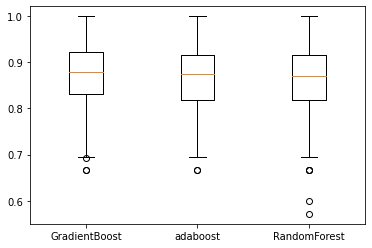

In [ ]:
from matplotlib import pyplot as plt
labels, data = [*zip(*f1_boot.items())]  # 'transpose' items to parallel key, value lists
plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

# **Functional Validation: Statistical testing**

**In this case, we use one sample and one tailed t-test.**

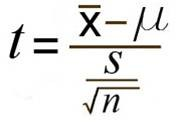

In [ ]:
#Hypothesis test for Random Forest 
#H0:The model is verified or mean = 0.84; HA: mean < 0.84
import statistics
import math
from scipy import stats

In [ ]:
pop_mean = {}
count = 0
for model in top_k_model:
  pop_mean[model] = f1score[count]
  count = count + 1
pop_mean
for model in top_k_model:
  test.functional_validation(f1_boot[model], pop_mean[model], model=model, alpha=0.05, alternative='less')

GradientBoost
Null Hypothesis: the accuracy of model is verified or H_0 =  0.8567823343848581
Alternative Hypothesis: the accuracy of model is not verified or H_0 <  0.8567823343848581
The alpha:  0.05
The result with p-value  0.226566266526115 does not reject the Null Hypothesis and the functionality/accuracy of  GradientBoost  is verified.
adaboost
Null Hypothesis: the accuracy of model is verified or H_0 =  0.8525845564773453
Alternative Hypothesis: the accuracy of model is not verified or H_0 <  0.8525845564773453
The alpha:  0.05
The result with p-value  0.0684429664747484 does not reject the Null Hypothesis and the functionality/accuracy of  adaboost  is verified.
RandomForest
Null Hypothesis: the accuracy of model is verified or H_0 =  0.8465116279069768
Alternative Hypothesis: the accuracy of model is not verified or H_0 <  0.8465116279069768
The alpha:  0.05
The result with p-value  0.47674665426635 does not reject the Null Hypothesis and the functionality/accuracy of  RandomF

In [ ]:
from numpy.random import seed
from scipy.stats import ttest_ind
# generate results
seed(1)

# model ranking after t-test
model_rank = []
# calculate the significance
i = 0
while i < len(top_k_model)-1:
  value, pvalue = ttest_ind(f1[top_k_model[i]], f1[top_k_model[i+1]], equal_var=False)
  print(value, pvalue)
  if pvalue > 0.05:
	  print('Samples are likely drawn from the same distributions (fail to reject H0)')
    model_rank.append(top_k_model[i],top_k_model[i+1])
  else:
	  print('Samples are likely drawn from different distributions (reject H0)')
    model_rank.append(top_k_model[i+1],top_k_model[i])

for model in model_rank:   
  if np.mean(f1[model])>0.85:
    print("Trust level of" + model +" is I")
  elif np.mean(f1[model])>0.6:
    print("Trust level of" + model +" is II")
  else:
    print("Trust level of" + model +" is III")

IndentationError: ignored

**Warning:** trust level is high does not necessarily indicate the model is good. Consider the test mean F1 score is 0.85 but the variance is high are not necessaily better than another one with 0.8 test mean F1 score but much lower variance. This is why we need hypothesis testing to rank model performance.

# **Assigning Trust Level**

In [ ]:

#trust model
def trust_level(prob):
  if prob <= 0.2:
    return('level 5')
  elif prob <= 0.4: 
    return('level 4')
  elif prob <= 0.6:
    return('level 3')
  elif prob <= 0.8:
    return('level 2')
  else:
    return('level 1')


def trust_model(df_trust,test_sdf=None, model = '',col_remain=['prediction', 'Probability', 'Trust Level']):
  variable1 = 'Probability'
  variable2 = 'Trust Level'
  if model == 'LogisticRegression':
    lr_model = LogisticRegressionModel.load("lr_model.model")
    predictions = lr_model.transform(test_sdf)
    df_trust = predictions.toPandas()
    df_trust.loc[:, variable1] = df_trust.probability.map(lambda x: x[1])
    df_trust[variable2] = df_trust.apply(lambda x: trust_level(x[variable1]), axis=1)
    return(df_trust[col_remain])
  elif model == 'Gaussian Naive Bayes':
    gnb_model = NaiveBayesModel.load("gnb_model.model")
    predictions = gnb_model.transform(test_sdf)
    df_trust = predictions.toPandas()
    df_trust.loc[:, variable1] = df_trust.probability.map(lambda x: x[1])
    df_trust[variable2] = df_trust.apply(lambda x: trust_level(x[variable1]), axis=1)
    return(df_trust[col_remain])
  elif model == 'SVM':
    lsvc_model = load("rf.joblib")
    prob= lsvc_model.predict_proba(df_trust)#.tolist()
    y_pred= lsvc_model.predict(df_trust)
    df_trust['prediction'] = y_pred    
    df_trust[variable1] = prob[:,1]
    df_trust[variable2] = df_trust.apply(lambda x: trust_level(x[variable1]), axis=1)
    return(df_trust[col_remain])
  elif model == 'RandomForest':
    rf_model = load('rf.joblib') 
    prob= rf_model.predict_proba(df_trust)
    y_pred= rf_model.predict(df_trust)
    df_trust['prediction'] = y_pred     
    df_trust[variable1] = prob[:,1]
    df_trust[variable2] = df_trust.apply(lambda x: trust_level(x[variable1]), axis=1)
    return(df_trust[col_remain])
  elif model == "GradientBoost":
    gb_model = load('gb.joblib') 
    prob= gb_model.predict_proba(df_trust)
    y_pred= gb_model.predict(df_trust)
    df_trust['prediction'] = y_pred
    df_trust[variable1] = prob[:,1]
    df_trust[variable2] = df_trust.apply(lambda x: trust_level(x[variable1]), axis=1)
    return(df_trust[col_remain])
  elif model == "adaboost":
    ada_model = load('ada.joblib') 
    prob= ada_model.predict_proba(df_trust)
    y_pred= ada_model.predict(df_trust)
    df_trust['prediction'] = y_pred
    df_trust[variable1] = prob[:,1]
    df_trust[variable2] = df_trust.apply(lambda x: trust_level(x[variable1]), axis=1)
    return(df_trust[col_remain])
  elif model =="Neural Nets":
    neural_net = keras.models.load_model("nn.model")   
    prob= neural_net.predict_proba(df_trust)
    y_pred= neural_net.predict(df_trust)
    df_trust['prediction'] = y_pred
    df_trust[variable1] = prob[:,0]
    df_trust[variable2] = df_trust.apply(lambda x: trust_level(x[variable1]), axis=1)
    return(df_trust[col_remain])


In [ ]:
for model in top_k_model:
  if model in ['Gaussian Naive Bayes','LogisticRegression']:
    all_columns = list(X.columns.values) + ['isFraud']
    df = np.column_stack((X[:100000],y[:100000])) 
    df = pd.DataFrame(df,columns = all_columns)
    df_sdf = test.spark_pre(df,'isFraud')
    df_t = trust_model(X[:100000],df_sdf,model = model) 
    file_name = model + '.csv'
    df_t.to_csv(file_name)
  else:
    df_t = trust_model(X[:100000],model = model,col_remain=['prediction','Trust Level'])
    file_name = model + '.csv'
    df_t.to_csv(file_name)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

# **DataFrames**

In [ ]:
RandomForest_df = pd.read_csv('RandomForest.csv',index_col=0)
RandomForest_df = RandomForest_df.rename(columns={"prediction": "Random Forest Prediction","Trust Level": "Random Forest Trust Level"})
RandomForest_df = pd.concat([fraud_df_orig[:100000], RandomForest_df], axis=1)
RandomForest_df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,transaction_accounts,Random Forest Prediction,Random Forest Trust Level
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.00,0.00,0,0,CM,0,level 5
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.00,0.00,0,0,CM,0,level 5
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.00,0.00,1,0,CC,1,level 1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.00,0.00,1,0,CC,1,level 1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.00,0.00,0,0,CM,0,level 5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,10,PAYMENT,4020.66,C1410794718,159929.0,155908.34,M1257036576,0.00,0.00,0,0,CM,0,level 5
99996,10,PAYMENT,18345.49,C744303677,6206.0,0.00,M1785344556,0.00,0.00,0,0,CM,0,level 5
99997,10,CASH_IN,183774.91,C104331851,39173.0,222947.91,C36392889,54925.05,0.00,0,0,CC,0,level 5
99998,10,CASH_OUT,82237.17,C707662966,6031.0,0.00,C1553004158,592635.66,799140.46,0,0,CC,0,level 5


In [ ]:
adaboost_df = pd.read_csv('adaboost.csv',index_col=0)
adaboost_df = adaboost_df.rename(columns={"prediction": "Adaboost Prediction","Trust Level": "Adaboost Trust Level"})
adaboost_df = pd.concat([fraud_df_orig[:100000], adaboost_df], axis=1)
adaboost_df


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Adaboost Prediction,Adaboost Trust Level
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.00,0.00,0,0,0,level 5
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.00,0.00,0,0,0,level 5
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.00,0.00,1,0,1,level 1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.00,0.00,1,0,1,level 1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.00,0.00,0,0,0,level 5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,10,PAYMENT,4020.66,C1410794718,159929.0,155908.34,M1257036576,0.00,0.00,0,0,0,level 5
99996,10,PAYMENT,18345.49,C744303677,6206.0,0.00,M1785344556,0.00,0.00,0,0,0,level 5
99997,10,CASH_IN,183774.91,C104331851,39173.0,222947.91,C36392889,54925.05,0.00,0,0,0,level 5
99998,10,CASH_OUT,82237.17,C707662966,6031.0,0.00,C1553004158,592635.66,799140.46,0,0,0,level 5


In [ ]:
GradientBoost_df = pd.read_csv('GradientBoost.csv',index_col=0)
GradientBoost_df = GradientBoost_df.rename(columns={"prediction": "GradientBoost Prediction","Trust Level": "GradientBoost Trust Level"})
GradientBoost_df = pd.concat([fraud_df_orig[:100000], GradientBoost_df], axis=1)
GradientBoost_df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,GradientBoost Prediction,GradientBoost Trust Level
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.00,0.00,0,0,0,level 5
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.00,0.00,0,0,0,level 5
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.00,0.00,1,0,1,level 1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.00,0.00,1,0,1,level 1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.00,0.00,0,0,0,level 5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,10,PAYMENT,4020.66,C1410794718,159929.0,155908.34,M1257036576,0.00,0.00,0,0,0,level 5
99996,10,PAYMENT,18345.49,C744303677,6206.0,0.00,M1785344556,0.00,0.00,0,0,0,level 5
99997,10,CASH_IN,183774.91,C104331851,39173.0,222947.91,C36392889,54925.05,0.00,0,0,0,level 5
99998,10,CASH_OUT,82237.17,C707662966,6031.0,0.00,C1553004158,592635.66,799140.46,0,0,0,level 5


In [ ]:
final_df = pd.concat([GradientBoost_df,adaboost_df[['Adaboost Prediction','Adaboost Trust Level']],RandomForest_df[['Random Forest Prediction','Random Forest Trust Level']]], axis=1)
final_df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,GradientBoost Prediction,GradientBoost Trust Level,Adaboost Prediction,Adaboost Trust Level,Random Forest Prediction,Random Forest Trust Level
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.00,0.00,0,0,0,level 5,0,level 5,0,level 5
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.00,0.00,0,0,0,level 5,0,level 5,0,level 5
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.00,0.00,1,0,1,level 1,1,level 1,1,level 1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.00,0.00,1,0,1,level 1,1,level 1,1,level 1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.00,0.00,0,0,0,level 5,0,level 5,0,level 5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,10,PAYMENT,4020.66,C1410794718,159929.0,155908.34,M1257036576,0.00,0.00,0,0,0,level 5,0,level 5,0,level 5
99996,10,PAYMENT,18345.49,C744303677,6206.0,0.00,M1785344556,0.00,0.00,0,0,0,level 5,0,level 5,0,level 5
99997,10,CASH_IN,183774.91,C104331851,39173.0,222947.91,C36392889,54925.05,0.00,0,0,0,level 5,0,level 5,0,level 5
99998,10,CASH_OUT,82237.17,C707662966,6031.0,0.00,C1553004158,592635.66,799140.46,0,0,0,level 5,0,level 5,0,level 5


In [ ]:
final_df['Combined Value'] = final_df['Random Forest Trust Level'].str[-2:].astype(int)+final_df['GradientBoost Trust Level'].str[-2:].astype(int)+final_df['Adaboost Trust Level'].str[-2:].astype(int)
final_df
# create a list of our conditions
conditions = [
    (final_df['Combined Value'] <= 3),
    (final_df['Combined Value'] > 3) & (final_df['Combined Value'] <= 6),
    (final_df['Combined Value'] > 6) & (final_df['Combined Value'] <= 9),
    (final_df['Combined Value'] > 9) & (final_df['Combined Value'] <= 12),
    (final_df['Combined Value'] > 12)
    ]

# create a list of the values we want to assign for each condition
values = ['level 1', 'level 2', 'level 3', 'level 4','level 5']

final_df['Combined Trust Level'] = np.select(conditions, values)
final_df=final_df.drop(["Combined Value"],axis=1)
final_df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,GradientBoost Prediction,GradientBoost Trust Level,Adaboost Prediction,Adaboost Trust Level,Random Forest Prediction,Random Forest Trust Level,Combined Trust Level
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.00,0.00,0,0,0,level 5,0,level 5,0,level 5,level 5
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.00,0.00,0,0,0,level 5,0,level 5,0,level 5,level 5
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.00,0.00,1,0,1,level 1,1,level 1,1,level 1,level 1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.00,0.00,1,0,1,level 1,1,level 1,1,level 1,level 1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.00,0.00,0,0,0,level 5,0,level 5,0,level 5,level 5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,10,PAYMENT,4020.66,C1410794718,159929.0,155908.34,M1257036576,0.00,0.00,0,0,0,level 5,0,level 5,0,level 5,level 5
99996,10,PAYMENT,18345.49,C744303677,6206.0,0.00,M1785344556,0.00,0.00,0,0,0,level 5,0,level 5,0,level 5,level 5
99997,10,CASH_IN,183774.91,C104331851,39173.0,222947.91,C36392889,54925.05,0.00,0,0,0,level 5,0,level 5,0,level 5,level 5
99998,10,CASH_OUT,82237.17,C707662966,6031.0,0.00,C1553004158,592635.66,799140.46,0,0,0,level 5,0,level 5,0,level 5,level 5


In [ ]:
final_df.to_csv('fraud.csv')
from google.colab import files
files.download('fraud.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>